<a href="https://colab.research.google.com/github/ayajnik/Multi-step-forecast-using-RNN-and-LSTM/blob/master/Multi_step_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing the libraries

from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()



mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('Libraries Imported.')

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Libraries Imported.


In [2]:
#importing the file

df = pd.read_csv("06585Data.csv", error_bad_lines=True)
print('\n')
print ('Files Imported.')
print('\n')
print(df.head(5))
print ('\n')
print (df.info)
print('The number of values in this dataset is', len(df))
print ('\n')



Files Imported.


          dateLastFulfillment  productId  ... unitPrice    soId
0  2019-10-07 16:52:36.131000        203  ...     90.98  145529
1  2019-10-07 16:49:57.832000        203  ...     90.98  145301
2  2019-10-07 16:46:56.460000        203  ...     90.98  145382
3  2019-10-04 16:31:28.387000        203  ...     90.98  145221
4  2019-10-03 16:32:39.874000        203  ...     90.98  145033

[5 rows x 8 columns]


<bound method DataFrame.info of              dateLastFulfillment  productId  ... unitPrice    soId
0     2019-10-07 16:52:36.131000        203  ...     90.98  145529
1     2019-10-07 16:49:57.832000        203  ...     90.98  145301
2     2019-10-07 16:46:56.460000        203  ...     90.98  145382
3     2019-10-04 16:31:28.387000        203  ...     90.98  145221
4     2019-10-03 16:32:39.874000        203  ...     90.98  145033
...                          ...        ...  ...       ...     ...
3792                         NaN        203  ...     95.98  134119
3793

In [3]:
#looking at the column names
for col in df.columns:
    print ("Variables that we are dealing with are:")
    print('\n')
    print(col)
    print ('\n')

Variables that we are dealing with are:


dateLastFulfillment


Variables that we are dealing with are:


productId


Variables that we are dealing with are:


productNum


Variables that we are dealing with are:


qtyFulfilled


Variables that we are dealing with are:


qtyOrdered


Variables that we are dealing with are:


totalPrice


Variables that we are dealing with are:


unitPrice


Variables that we are dealing with are:


soId




In [4]:
#targeting the variables that we want to consider
features_considered = ['qtyFulfilled', 'totalPrice', 'unitPrice']

features = df[features_considered]
features.index = df['dateLastFulfillment']
features.head()



,qtyFulfilled,totalPrice,unitPrice
dateLastFulfillment,,,
2019-10-07 16:52:36.131000,2.0,181.96,90.98
2019-10-07 16:49:57.832000,1.0,90.98,90.98
2019-10-07 16:46:56.460000,2.0,181.96,90.98
2019-10-04 16:31:28.387000,1.0,90.98,90.98
2019-10-03 16:32:39.874000,1.0,90.98,90.98


In [0]:
TRAIN_SPLIT = 2500
tf.set_random_seed(13)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f974d256fd0>,
      dtype=object)

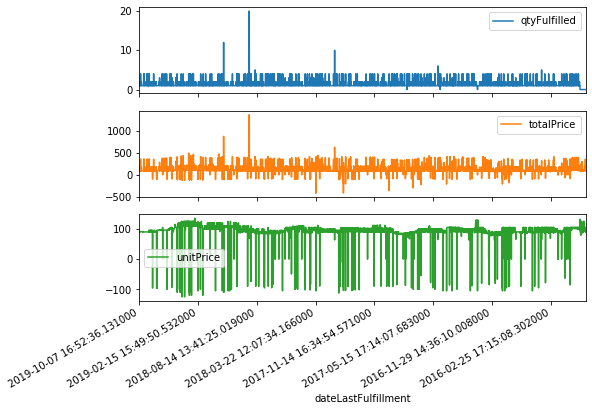

In [6]:
#plotting the dataframe
features.plot(subplots=True)

In [0]:
#normalizing the dataset in order to handle the outliers

dataset = features.values
data_mean = dataset.mean(axis=0)
data_std = dataset.std(axis=0)

dataset = (dataset-data_mean)/data_std

In [8]:
dataset

array([[ 0.84833505,  0.7683441 ,  0.04271963],
       [-0.32983912, -0.29194185,  0.04271963],
       [ 0.84833505,  0.7683441 ,  0.04271963],
       ...,
       [-1.50801329,  2.84229979,  0.01458442],
       [-1.50801329, -0.12878508,  0.43661252],
       [-1.50801329, -0.30359591,  0.01458442]])

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [11]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [12]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [14]:
EVALUATION_INTERVAL = 200
EPOCHS = 20


single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 38s 188ms/step - loss: 0.4855 - val_loss: 0.3843
Epoch 2/20
200/200 [==============================] - 35s 175ms/step - loss: 0.4772 - val_loss: 0.3880
Epoch 3/20
200/200 [==============================] - 35s 174ms/step - loss: 0.4753 - val_loss: 0.3897
Epoch 4/20
200/200 [==============================] - 35s 174ms/step - loss: 0.4729 - val_loss: 0.3872
Epoch 5/20
200/200 [==============================] - 35s 174ms/step - loss: 0.4722 - val_loss: 0.3917
Epoch 6/20
200/200 [==============================] - 35s 174ms/step - loss: 0.4710 - val_loss: 0.3875
Epoch 7/20
200/200 [==============================] - 35s 175ms/step - loss: 0.4700 - val_loss: 0.3860
Epoch 8/20
200/200 [==============================] - 35s 175ms/step - loss: 0.4688 - val_loss: 0.3902
Epoch 9/20
200/200 [==============================] - 35s 174ms/step - loss: 0.4676 - val_loss: 0.3895
Epoch 10/20
200/200 [=========

In [0]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

In [0]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

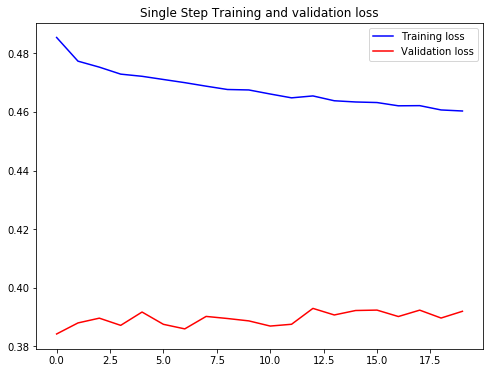

In [16]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

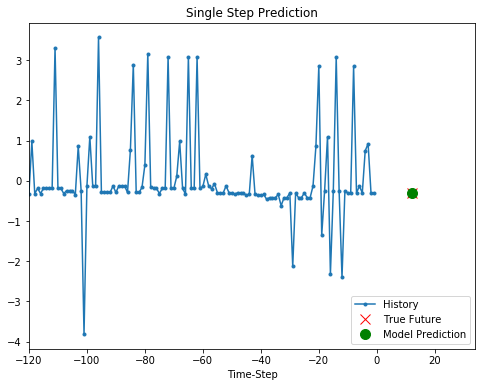

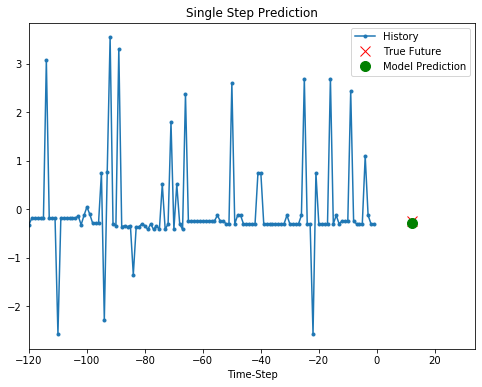

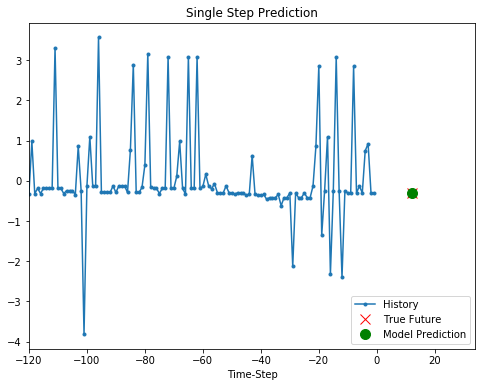

In [25]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [0]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [27]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (120, 3)

 Target temperature to predict : (72,)


In [0]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [0]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

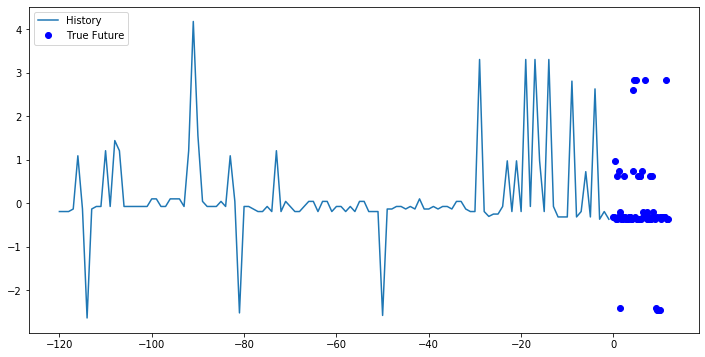

In [30]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [0]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [32]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(256, 72)


In [33]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/20
200/200 [==============================] - 69s 346ms/step - loss: 0.4889 - val_loss: 0.3822
Epoch 2/20
200/200 [==============================] - 65s 327ms/step - loss: 0.4721 - val_loss: 0.3807
Epoch 3/20
200/200 [==============================] - 65s 325ms/step - loss: 0.4704 - val_loss: 0.3803
Epoch 4/20
200/200 [==============================] - 65s 327ms/step - loss: 0.4691 - val_loss: 0.3833
Epoch 5/20
200/200 [==============================] - 66s 329ms/step - loss: 0.4673 - val_loss: 0.3810
Epoch 6/20
200/200 [==============================] - 66s 329ms/step - loss: 0.4666 - val_loss: 0.3807
Epoch 7/20
200/200 [==============================] - 66s 329ms/step - loss: 0.4660 - val_loss: 0.3841
Epoch 8/20
200/200 [==============================] - 65s 326ms/step - loss: 0.4658 - val_loss: 0.3826
Epoch 9/20
200/200 [==============================] - 65s 326ms/step - loss: 0.4654 - val_loss: 0.3816
Epoch 10/20
200/200 [=========

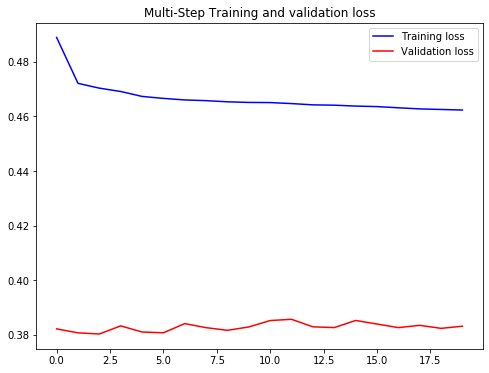

In [34]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

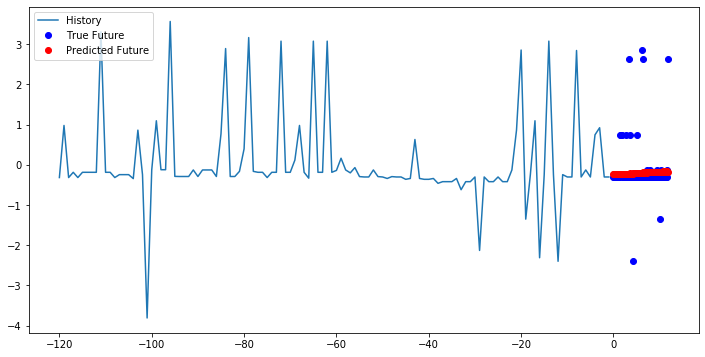

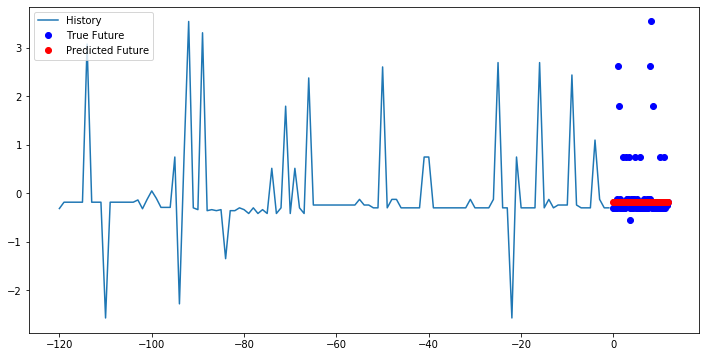

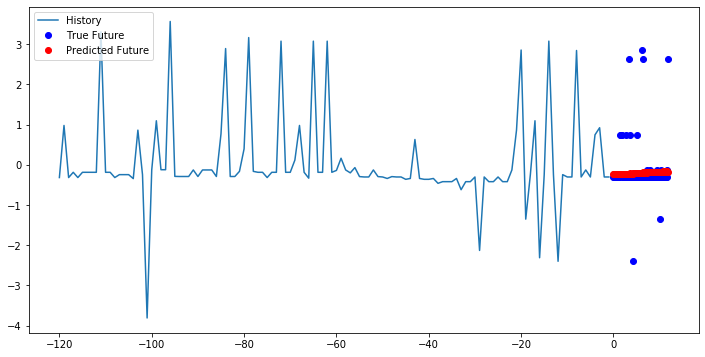

In [35]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])